In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import sigpy as sp
import sigpy.plot as pl


plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.edgecolor'] = 'w'
plt.rcParams["savefig.bbox"] = 'tight'

figname = "03_comparebart.png"

In [2]:
# helper function from https://github.com/mrirecon/bart
def readcfl(name):
    # get dims from .hdr
    with open(name + ".hdr", "rt") as h:
        h.readline() # skip
        l = h.readline()
    dims = [int(i) for i in l.split()]

    # remove singleton dimensions from the end
    n = np.prod(dims)
    dims_prod = np.cumprod(dims)
    dims = dims[:np.searchsorted(dims_prod, n)+1]

    # load data and reshape into dims
    with open(name + ".cfl", "rb") as d:
        a = np.fromfile(d, dtype=np.complex64, count=n)
    return a.reshape(dims, order='F') # column-major

In [3]:
sgpy_ref = np.load("../data/training/case000/ref_2min.npy")
sgpy_ref = sp.fft(sgpy_ref, axes=(-1,))
sgpy_ref /= np.linalg.norm(sgpy_ref[..., 0])

In [4]:
brt_ref = readcfl("../data/training/case000/bartrecon_2min").squeeze()
brt_ref /= np.linalg.norm(brt_ref[..., 0])

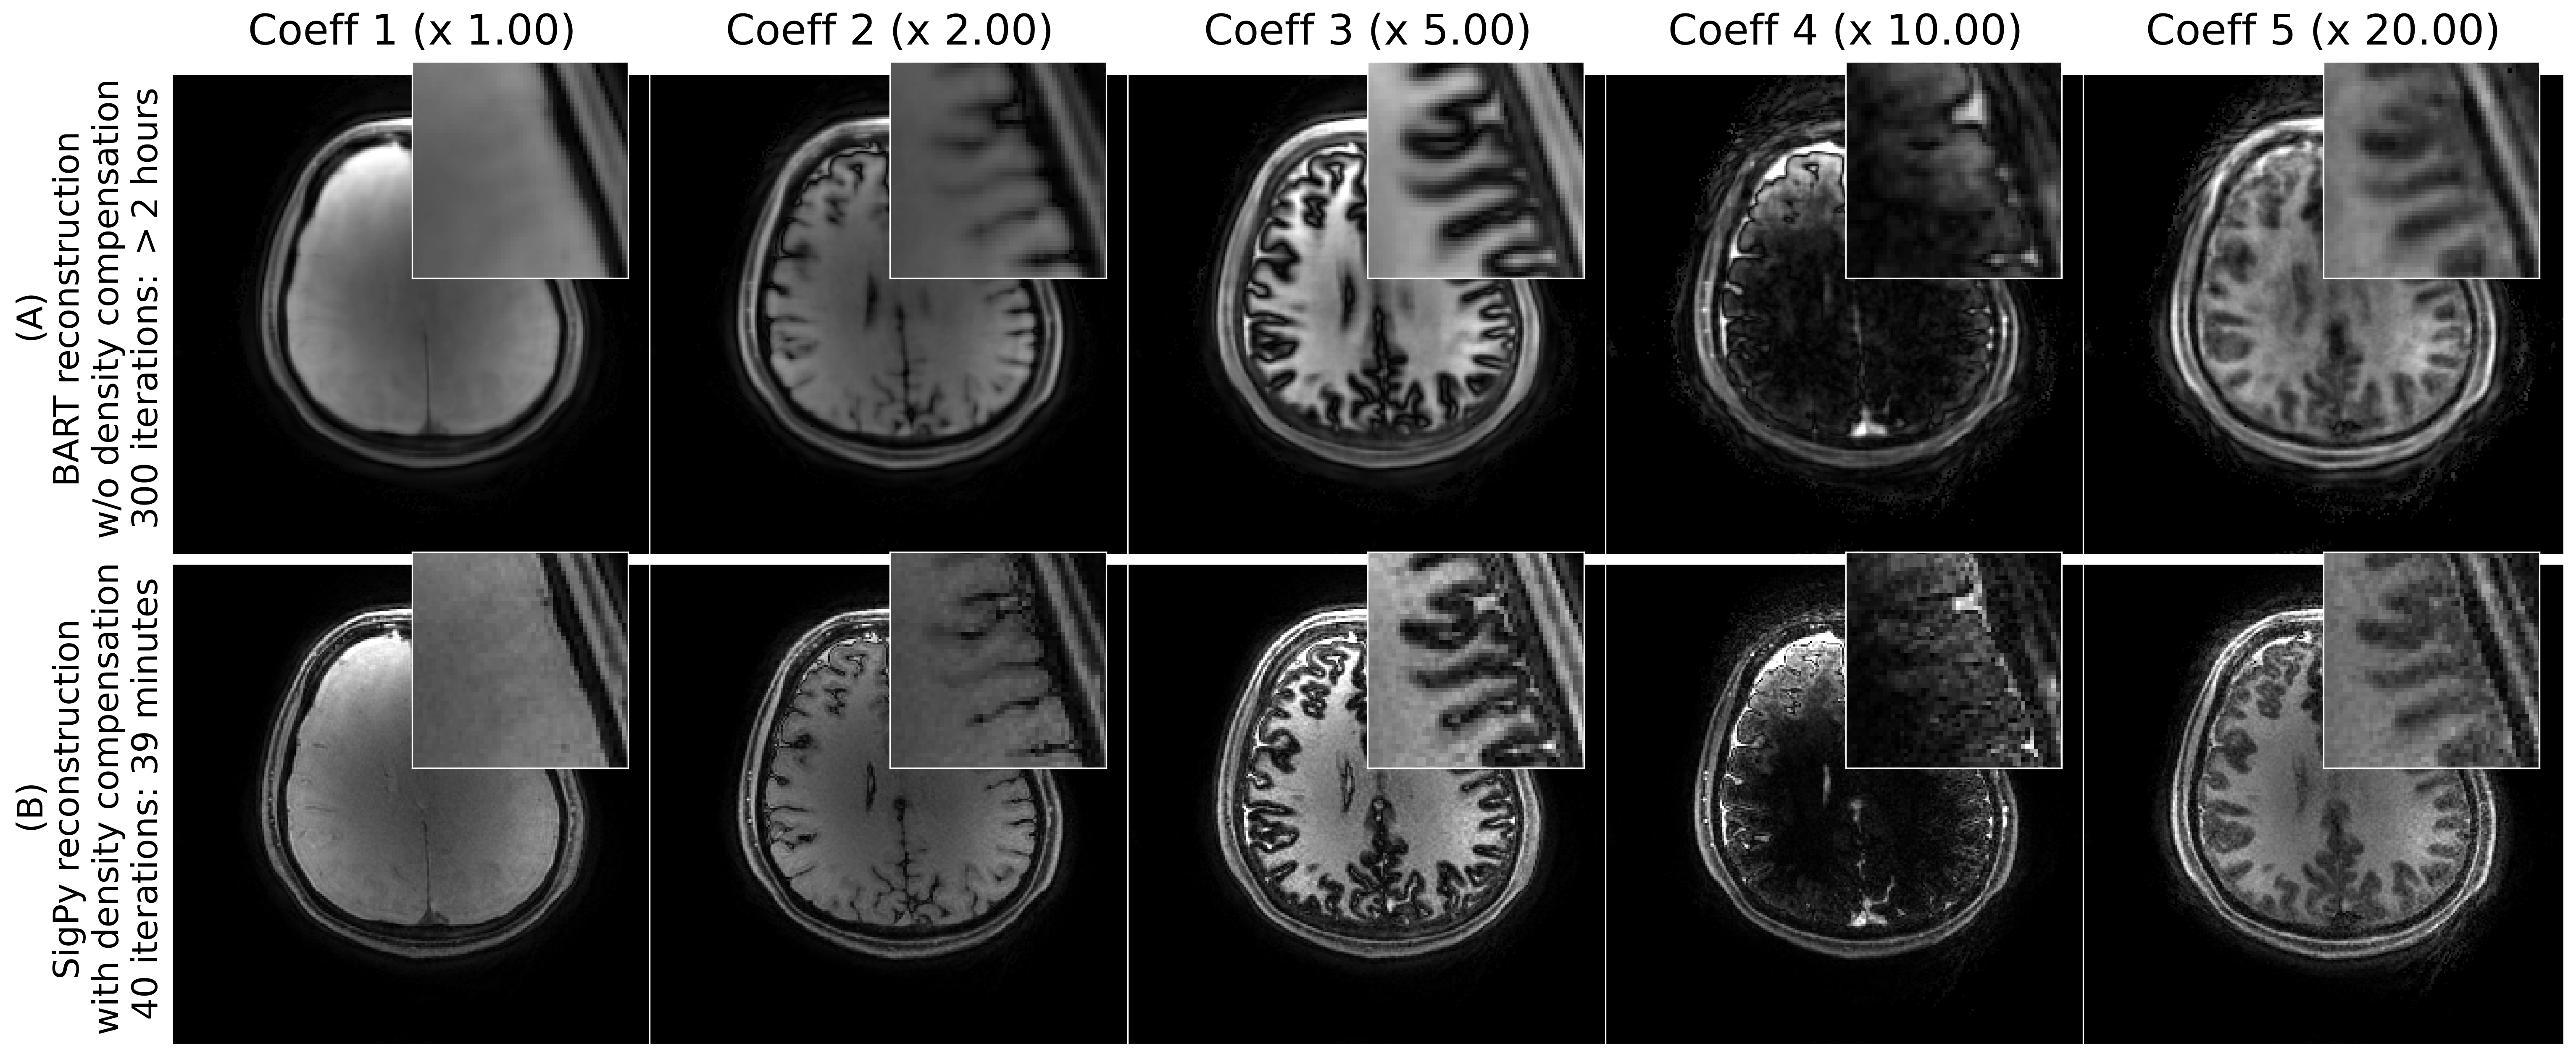

In [5]:
vmax = np.max(np.abs(sgpy_ref).ravel())*0.5
scales = [1, 2, 5, 10, 20]
tk = sgpy_ref.shape[-1]
msk = ((np.abs(np.abs(sgpy_ref)[..., 0])/np.linalg.norm(np.abs(sgpy_ref)[..., 0])) > 0.00001)

fig, axs = plt.subplots(2, tk, figsize=(tk * 5, 10), dpi=300)

def helper(ax, arr):
    tmp = np.abs(arr)
    ax.imshow(tmp, cmap="gray", vmin=0, vmax=vmax)
    
    axins = ax.inset_axes([0.5, 0.575, 0.45, 0.45])
    axins.imshow(tmp, cmap="gray", vmin=0, vmax=vmax)
    axins.set_xlim(160, 210)
    axins.set_ylim(130,  80)
    axins.set_xticks([])
    axins.set_yticks([])


for k in range(tk):
    helper(axs[0][k], (scales[k]*brt_ref[...,k]*msk)[:, ::-1, 170].T)
    helper(axs[1][k], (scales[k]*sgpy_ref[...,k]*msk)[:, ::-1, 170].T)    
    axs[0][k].set_title("Coeff %d (x %0.2f)" % (k + 1, scales[k]), fontsize=24, pad=10)

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

axs[0][0].set_ylabel("(A)\n BART reconstruction\n w/o density compensation\n 300 iterations: $> 2$ hours", fontsize=20)
axs[1][0].set_ylabel("(B)\n SigPy reconstruction\n with density compensation\n 40 iterations: 39 minutes", fontsize=20)

plt.subplots_adjust(wspace=-0.1, hspace=0.02)
plt.savefig(figname)